In [1]:
# %pip uninstall torch torchvision torchaudio transformers mamba-ssm tqdm pandas scikit-learn numpy -y
# %pip cache purge
# %pip install peft torch transformers mamba-ssm tqdm pandas scikit-learn numpy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [3]:
splice_df = pd.read_csv('splice_sites_full_centered_balanced_correct_V3.csv')
splice_df.head()

,id,coord,kind,transcript,strand,chrom,start,end,sequence,win_start,win_end,is_truncated,motif_len,motif
0,NC_050096.1_35318_donor,35318,0,XM_020544715.3,+,NC_050096.1,35319,35320,GGGCCCGGCTGGGCCTCAGCGGGGTCGTCGAGATGGAGATGGGGAG...,35118,35520,False,2,GT
1,NC_050096.1_34607_acceptor,34607,1,XM_020544715.3,+,NC_050096.1,34605,34606,TCCGGTGATTAATTTGTCCTTATACCTTTACAACAAAAATTCACTA...,34404,34806,False,2,TG
2,NC_050096.1_36174_donor,36174,0,XM_020544715.3,+,NC_050096.1,36175,36176,ATAATATGTTCATTATATCACAACACTCTTTTCTTATGGAGTCGTG...,35974,36376,False,2,GT
3,NC_050096.1_36037_acceptor,36037,1,XM_020544715.3,+,NC_050096.1,36035,36036,GCACAAAACTAACTAAAGGAATCATTCTGATAGATAACACTATAAA...,35834,36236,False,2,AG
4,NC_050096.1_36504_donor,36504,0,XM_020544715.3,+,NC_050096.1,36505,36506,TGTCATTTCCTTACCTCATTGAATCATTTCCGATGCTTCTTCTCTG...,36304,36706,False,2,GT


In [4]:
# Split data with stratification
train_df, temp_df = train_test_split(splice_df, test_size=0.3, stratify=splice_df['kind'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['kind'], random_state=42)

## Full Pipeline

In [5]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4


In [6]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig
from mamba_ssm import Mamba
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
# Cell 2: Dataset Class (Modified)
class DNASequenceAndEmbeddingDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, bert_model, device, max_length=512):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.device = device
        self.max_length = max_length
        
        # Nucleotide to index mapping
        self.nuc_to_idx = {
            'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4,
            'P': 5  # P for padding
        }
        
        # Pre-compute embeddings and encodings
        # Pre-compute embeddings and encodings
        self.embeddings = []
        self.seq_encodings = []
        
        with torch.no_grad():
            for seq in tqdm(sequences, desc="Computing embeddings"):
                # Get BERT embeddings
                inputs = self.tokenizer(
                    seq,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt"
                )
                inputs = {k: v.to(device) for k, v in inputs.items()}
                outputs = self.bert_model(**inputs)
                # DNABERT-2 returns a tuple where the first element is hidden states
                embeddings = outputs[0].cpu()  # Changed this line
                self.embeddings.append(embeddings)
                
                # Create sequence encoding
                seq_encoding = torch.tensor([
                    self.nuc_to_idx.get(nuc, self.nuc_to_idx['N']) 
                    for nuc in (seq[:max_length] + 'P' * max(0, max_length - len(seq)))
                ], dtype=torch.long)
                self.seq_encodings.append(seq_encoding)
        
        # Convert labels to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx].squeeze(0),
            'sequence': self.seq_encodings[idx],
            'label': self.labels[idx]
        }

In [20]:
# Cell 3: Model Architecture
from peft import LoraConfig, get_peft_model, TaskType

class DNABertMambaWithSequenceClassifier(nn.Module):
    def __init__(self, bert_model, d_model=768, n_classes=3, d_state=16, d_conv=4, expand=2, num_mamba_layers=4):
        super().__init__()
        
        # Apply LoRA to BERT model
        
        # Helper: Collect linear module names from DNABERT
        def find_linear_layer_names(model):
            target_names = set()
            for name, module in model.named_modules():
                if isinstance(module, torch.nn.Linear):
                    # Only take the leaf module name
                    if '.' in name:
                        target_names.add(name.split('.')[-1])
                    else:
                        target_names.add(name)
            return list(target_names)
        
        # Inside your model init
        target_modules = find_linear_layer_names(bert_model)
        print("found linear target modules:", target_modules)
        print("targeting linear target modules:", ["Wqkv", "dense"])
        
        lora_config = LoraConfig(
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            task_type=TaskType.FEATURE_EXTRACTION,
            target_modules=["Wqkv", "dense"]
            # target_modules=target_modules
        )

        self.bert_model = get_peft_model(bert_model, lora_config)
        
        # Nucleotide embedding
        self.nuc_embedding = nn.Embedding(6, 32)  # 6 tokens (ACGTN + PAD), 32 dimensions
        
        # Combine sequence and BERT embeddings
        self.combine_layer = nn.Sequential(
            nn.LayerNorm(d_model + 32),  # Normalize *before* the Linear layer
            nn.Linear(d_model + 32, d_model),
            nn.GELU(), # I used GeLU instead of ReLU since was encountering model collapse
            nn.Dropout(0.1)
        )

        # Mamba configuration with deeper layers
        self.mamba = nn.Sequential(*[
            Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand,
                use_fast_path=True
            ) for _ in range(num_mamba_layers)
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.1),
            nn.Linear(d_model, n_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, embeddings, sequence, labels=None):
        # Get nucleotide embeddings
        seq_embeddings = self.nuc_embedding(sequence)
        
        # Combine BERT embeddings with sequence embeddings
        combined = torch.cat([embeddings, seq_embeddings], dim=-1)
        x = self.combine_layer(combined)
        
        # Pass through Mamba layers after clamp
        x = torch.clamp(x, -10.0, 10.0)
        
        x = self.mamba(x)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Classification
        logits = self.classifier(x)
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits
        return None, logits

In [21]:
# Cell 4: Model Initialization (Modified)
def prepare_model_and_data(train_df, test_df, sample_size=5000):
    # Sample the data (keeping the stratified sampling)
    train_sample_size = min(sample_size, len(train_df))
    test_sample_size = min(sample_size//5, len(test_df))
    
    train_df_sample = train_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), train_sample_size // 3))
    ).reset_index(drop=True)
    
    test_df_sample = test_df.groupby('kind', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), test_sample_size // 3))
    ).reset_index(drop=True)
    
    # Initialize BERT
    model_name = "zhihan1996/DNABERT-2-117M"
    
    # Create config first
    config = AutoConfig.from_pretrained(
        model_name,
        trust_remote_code=True
    )
    
    # Modify config to use standard attention
    config.attention_probs_dropout_prob = 0.1
    config.hidden_dropout_prob = 0.1
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    
    # Initialize BERT model
    bert_model = AutoModel.from_pretrained(
        model_name,
        config=config,
        trust_remote_code=True
    )
    
    # Force model to float32
    bert_model = bert_model.float()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Freeze BERT and move to device
    for param in bert_model.parameters():
        param.requires_grad = False
    bert_model = bert_model.to(device)
    
    # Create datasets
    train_dataset = DNASequenceAndEmbeddingDataset(
        sequences=train_df_sample['sequence'].tolist(),
        labels=train_df_sample['kind'].tolist(),
        tokenizer=tokenizer,
        bert_model=bert_model,
        device=device
    )
    
    test_dataset = DNASequenceAndEmbeddingDataset(
        sequences=test_df_sample['sequence'].tolist(),
        labels=test_df_sample['kind'].tolist(),
        tokenizer=tokenizer,
        bert_model=bert_model,
        device=device
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Initialize model with LoRA and deeper Mamba layers
    model = DNABertMambaWithSequenceClassifier(
        bert_model=bert_model,
        d_model=768,
        n_classes=3,
        d_state=16,
        d_conv=4,
        expand=2,
        num_mamba_layers=4  # Increased number of layers
    )
    model = model.to(device)

    # Sanity check for DNABERT tokenizer
    example_seq = train_df_sample['sequence'].iloc[0]
    print("Original sequence:", example_seq)
    
    # Check tokens
    tokens = tokenizer.tokenize(example_seq)
    print("Tokenized:", tokens)
    
    # Check input ids
    inputs = tokenizer(example_seq, return_tensors="pt", padding="max_length", max_length=512, truncation=True)
    print("Input IDs shape:", inputs['input_ids'].shape)
    print("First few IDs:", inputs['input_ids'][0, :10])
    
    return model, train_dataloader, test_dataloader, device

In [22]:
# not good
def unfreeze_bert_layers(model, num_layers_to_unfreeze, max_layers=6):
    encoder_layers = model.bert_model.base_model.encoder.layer
    total_layers = len(encoder_layers)

    # Enforce max cap
    num_layers_to_unfreeze = min(num_layers_to_unfreeze, max_layers)

    for i in range(total_layers - num_layers_to_unfreeze, total_layers):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True

    if hasattr(model.bert_model.base_model, 'pooler'):
        for param in model.bert_model.base_model.pooler.parameters():
            param.requires_grad = True


In [45]:
# Cell 5: Training Function (Modified)
def train_model(model, train_dataloader, val_dataloader, device, 
                num_epochs=10, patience=3, learning_rate=1e-4, 
                unfreeze_every_x_epoch=0, max_unfreeze_layers=0):
    
    # Initialize optimizer and tracking variables
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Initialize tracking lists
    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [], 'learning_rate': []
    }
    
    for epoch in range(num_epochs):

        if (unfreeze_every_x_epoch != 0) and (epoch % unfreeze_every_x_epoch == 0):
            layers_to_unfreeze = epoch // unfreeze_every_x_epoch + 1
            if not (layers_to_unfreeze > max_unfreeze_layers):    
                print(f"\n[INFO] Unfreezing top {layers_to_unfreeze} BERT layers...\n")
                unfreeze_bert_layers(model, layers_to_unfreeze, max_layers=max_unfreeze_layers)

        # trainable = [name for name, param in model.named_parameters() if param.requires_grad]
        # print(f"[INFO] Trainable parameters after unfreezing: {len(trainable)}")
        # for name in trainable:
        #     print(f" - {name}")

        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            embeddings = batch['embeddings'].to(device)
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)  # Changed from 'labels' to 'label'
            
            optimizer.zero_grad()
            loss, logits = model(embeddings, sequence, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                embeddings = batch['embeddings'].to(device)
                sequence = batch['sequence'].to(device)
                labels = batch['label'].to(device)  # Changed from 'labels' to 'label'
                
                loss, logits = model(embeddings, sequence, labels)
                total_val_loss += loss.item()
                
                # Calculate accuracy
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        history['learning_rate'].append(current_lr)
        
        # Print metrics
        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        print(f'Learning Rate: {current_lr}')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Convert history to DataFrame
    history_df = pd.DataFrame(history)
    return history_df

In [ ]:
# Cell 6: Run the Pipeline
# Initialize model and data
model, train_dataloader, test_dataloader, device = prepare_model_and_data(
    train_df=train_df,
    test_df=test_df,
    sample_size=10000
)

# Train the model
history_df = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    device=device,
    num_epochs=20,
    patience=10,
    learning_rate=1e-4,
    unfreeze_every_x_epoch=2,
    max_unfreeze_layers=4
)

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Computing embeddings:   0%|          | 0/9999 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/1998 [00:00<?, ?it/s]

found linear target modules: ['Wqkv', 'wo', 'gated_layers', 'dense']
targeting linear target modules: ['Wqkv', 'dense']
Original sequence: CAGCGAAGTTCTCCCAGTAAAAGCAGTCATAATGTAGTATTAGCCTGGACAGAACAATATTCGATCAGTTCCAGAGAGAAAGGAACGCTGATCCTTTGAAAACCCGTGTAATTTTATTTCCCTTTTCCTCTTTTTCCCCCCTAAGAGAACTGAAAATTCTTTGTTTTATGATAGGCATCTATATATACTTATTATCCTCTACAGATATTGTGATATGAAGGTGTTTTAGAAGTGTAAATTGCTCTTTAATGCGTGCTCTGGCACAATAGCACTGAAACCTCTTCAGTGAGGAGAGGACTCTGCCTTTACATATTACAGTCTCCGTTTCTCCCCATTTCGCAGCATGCTGCAACTTTTTTAAAACGTCATAACGATTTTAATGCCAACAGATTTTTGACTGTA
Tokenized: ['CAGC', 'GAAGTT', 'CTCC', 'CA', 'GTAAAA', 'GCAGTCA', 'TAATGTA', 'GTATTA', 'GCCTG', 'GACA', 'GAACAA', 'TATT', 'CGA', 'TCA', 'GTTCCA', 'GAGAGAAA', 'GGAA', 'CGCTGA', 'TCCTTTG', 'AAAA', 'CCCGTG', 'TAA', 'TTTTATT', 'TCCCTTTT', 'CCTCTTTT', 'TCCCCCC', 'TAA', 'GAGAA', 'CTG', 'AAAATT', 'CTTTG', 'TTTTA', 'TGATAGG', 'CATC', 'TATATATA', 'CTTATTA', 'TCCTCTA', 'CAGA', 'TATT', 'GTGA', 'TATGAA', 'GGTG', 'TTTTA', 'GAAGTG', 'TAAATT', 'GCTCTT', 'TAATG', 'CGTG',

Epoch 1/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 0.9767, Train Acc: 0.4798
Val Loss: 0.8367, Val Acc: 0.5626
Learning Rate: 0.0001


Epoch 2/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.8612, Train Acc: 0.5427
Val Loss: 0.8165, Val Acc: 0.5536
Learning Rate: 0.0001

[INFO] Unfreezing top 2 BERT layers...



Epoch 3/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.8127, Train Acc: 0.5608
Val Loss: 0.8283, Val Acc: 0.5541
Learning Rate: 0.0001


Epoch 4/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.7964, Train Acc: 0.5648
Val Loss: 0.8442, Val Acc: 0.5636
Learning Rate: 0.0001

[INFO] Unfreezing top 3 BERT layers...



Epoch 5/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: nan, Train Acc: 0.4618
Val Loss: nan, Val Acc: 0.3333
Learning Rate: 1e-05


Epoch 6/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: nan, Train Acc: 0.3333
Val Loss: nan, Val Acc: 0.3333
Learning Rate: 1e-05

[INFO] Unfreezing top 4 BERT layers...



Epoch 7/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: nan, Train Acc: 0.3333
Val Loss: nan, Val Acc: 0.3333
Learning Rate: 1e-05


Epoch 8/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: nan, Train Acc: 0.3333
Val Loss: nan, Val Acc: 0.3333
Learning Rate: 1.0000000000000002e-06


Epoch 9/20:   0%|          | 0/313 [00:00<?, ?it/s]

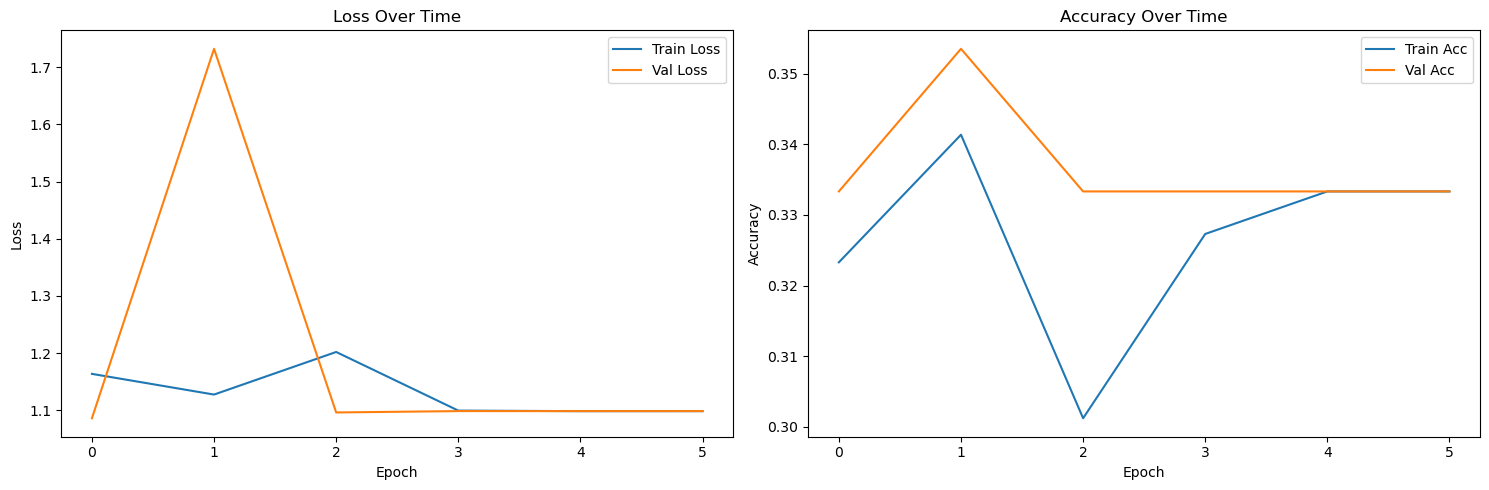

In [25]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Train Acc')
plt.plot(history_df['val_acc'], label='Val Acc')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Cell 7: Compute Test Accuracy
def compute_test_accuracy(model, test_dataloader, device):
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for batch in test_dataloader:
            embeddings = batch['embeddings'].to(device)
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            _, logits = model(embeddings, sequence)
            predictions = torch.argmax(logits, dim=1)
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
    
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute test accuracy
compute_test_accuracy(model, test_dataloader, device)

Test Accuracy: 0.5556
